In [1]:
# Import  libraries
import os  
import re  # For regular expressions to clean text
import time  # For timing operations
from collections import Counter  # For counting elements in a list
from queue import Queue  # For thread-safe queueing
from threading import Thread  # For multi-threading

import numpy as np 
import pandas as pd # For data manipulation
import matplotlib.pyplot as plt  # For viewing images
import cv2  
import pytesseract  # OCR library for extracting text from images
import easyocr  # Alternative OCR library
from ultralytics import YOLO  # For YOLO object detection model
import torch  # PyTorch for deep learning models
import shutil  # For file operations
from torchvision.transforms.v2.functional import crop_image  # For cropping images
from ultralytics.data.utils import verify_image  # For verifying images

In [2]:
# Path to Tesseract executable for OCR functionality
pytesseract.pytesseract.tesseract_cmd = r'C:\Program Files\Tesseract-OCR\tesseract.exe'

In [ ]:
#=======================================================
# ================== Helper Functions ==================
# Function to clean and format the extracted text
def clean_text(text, min_length=0, max_length=11):
    """
    Cleans and validates text extracted from images.
    - Removes invalid characters and trims whitespace.
    - Ensures text length is within the specified range.
    """
    if not text:
        return ""
    text = re.sub(r'[^A-Z0-9\-]', '', text)  # Keep only valid characters
    text = re.sub(r'^[\-]+', '', text)  # Remove leading hyphens
    text = re.sub(r'[\-]+$', '', text)  # Remove trailing hyphens
    text = text.strip()  # Trim whitespace
    if len(text) < min_length or len(text) > max_length:
        return ""
    return text
    
    
# Function to find the most frequent element in a list
def get_most_frequency(lst):
    """
    Returns the most common element in the list.
    """
    frequency = Counter(lst)
    return frequency.most_common(1)[0][0]
  
  
# Function to rotate an image for better OCR results
def rotate_image(image, angle):
    """
    Rotates the image by a given angle around its center.
    """
    image_center = tuple(np.array(image.shape[1::-1]) / 2)
    rot_mat = cv2.getRotationMatrix2D(image_center, angle, 1.0)
    result = cv2.warpAffine(image, rot_mat, image.shape[1::-1], flags=cv2.INTER_LINEAR)
    return result


# show image with matplotlib
def show_image_cv2_matplotlib(image):
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.show()
    
  
# ===================================================
# ================== OCR Functions ==================
# STEP1: Preprocess license plate images for OCR with blur, sharpening, and contrast enhancement
def preprocess_license_plate(plate_image):
    """
    Enhances the cropped license plate image for OCR:
    - Converts to grayscale, resizes, applies filters, sharpens, and increases contrast.
    """
    try:
        try:
            gray = cv2.cvtColor(plate_image, cv2.COLOR_BGR2GRAY)  # Convert to grayscale
        except:
            gray = plate_image

        gray = cv2.resize(gray, (250, 50), interpolation=cv2.INTER_CUBIC)  # Resize image
        img_clear = cv2.medianBlur(gray, 3)  # Apply median blur
        img_clear = cv2.edgePreservingFilter(img_clear, sigma_s=5)  # Edge-preserving filter
        gaussian = cv2.GaussianBlur(img_clear, (5, 5), 2)  # Gaussian blur for sharpening
        sharpened = cv2.addWeighted(img_clear, 2, gaussian, -1, 0)
        contrast = cv2.normalize(sharpened, None, 0, 255, cv2.NORM_MINMAX)  # Normalize contrast
        # thresholding: convert greyscale image to Black-and-White image (binary image)
        enhanced = cv2.adaptiveThreshold(contrast, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 11, 2) 
        
        # erosion: remove noise and make characters more visible
        kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (2, 2))
        eroded = cv2.erode(enhanced, kernel, iterations=1)

        return eroded
    except Exception as e:
        print("Error during license plate preprocessing:", e)
        return None
      
      
# STEP2: Extract text from license plate images using OCR with Tesseract
def predict_license_text(image):
    """
    Uses OCR to extract text from an image, with rotation adjustments for better accuracy.
    """
    if image is None:
        print("Image is None")
        return None
    else:
        text = pytesseract.image_to_string(image).strip()  # Extract text
        text = clean_text(text)

        # If text is empty or too short, try rotated images
        if text == "" or len(text) < 3:  
            texts = []

            # function to rotate image by angle and extract text
            def worker(angle):
                rotated_image = rotate_image(image, angle)
                rotated_text = pytesseract.image_to_string(rotated_image).strip()
                rotated_text = clean_text(rotated_text)
                if rotated_text:
                    texts.append(rotated_text)

            # Create threads for above Worker(): rotating images and extracting text
            threads = [Thread(target=worker, args=(angle,)) for angle in range(-5, 6)]
            for thread in threads:
                thread.start()
            for thread in threads:
                thread.join()

            if len(texts) == 0:
                return ""
            
            text_lengths = [len(t) for t in texts if len(t) > 2]
            final_length = get_most_frequency(text_lengths)
            final_text = ''.join(get_most_frequency([t[i] for t in texts if i < len(t)]) for i in range(final_length))
            return final_text

        return text

        

In [4]:
# ================== YOLO Model Functions ==================
# ===========for License Plate Detection and Recognition ==================
# Function to predict license plates in an image
def predict_license_plate_single(image, model, threshold=0.4):
    """
    Detects and reads license plates from a single image using a YOLO model and OCR.
    """
    try:
        # 1-Predict license plates in the image using YOLO
        predictions = model.predict(image, device=0, conf=threshold, verbose=False)
        
        # 2-Extract license plate text using OCR:
        # This will return a list of results, each containing a list of boxes, labels, and scores
        # We only consider first boxes with high confidence scores
        # then extract the license plate text using OCR
        for result in predictions:
            for box in result.boxes:
            # Only consider first box with high confidence score
                if box.conf[0] >= 0.6:  
                    # Extract coordinates and crop the license plate
                    x_min, y_min, x_max, y_max = map(int, box.xyxy[0])
                    crop_img = image[y_min:y_max, x_min:x_max]
                    if crop_img is None or crop_img.size == 0:
                        continue
                    
                    # preprocess the license plate image for OCR
                    crop_img = preprocess_license_plate(crop_img)
                    # OCR to extract text 
                    text = predict_license_text(crop_img)
                    
                    # draw rectangle and display text
                    cv2.rectangle(image, (x_min, y_min), (x_max, y_max), (0, 255, 0), 2)
                    cv2.putText(image, f"License Plate: {text or 'Unknown'}", (x_min, y_min - 10),
                                cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)
        return image
    except Exception as e:
        print("Error during license plate prediction:", e)
        return None

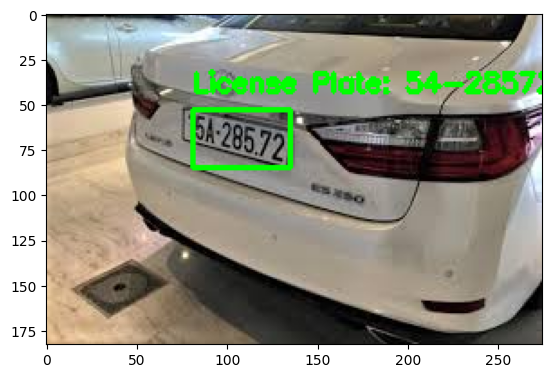

In [5]:
# Predict single image
image = cv2.imread(r"D:\Seneca\CVI\WS\Final_project\Preprocessing\data\predict_car_license_plate\input\images (1).jpeg")
model = YOLO('Preprocessing/data/yolo_car_plate_convert/runs/train/license_plate/weights/best.pt')
image = predict_license_plate_single(image, model)
show_image_cv2_matplotlib(image)

In [141]:
# # Process video for license plate detection
# video = cv2.VideoCapture(r'D:\Seneca\CVI\WS\Final_project\Preprocessing\data\demo\output\output.avi')
# while video.isOpened():
#     ret, frame = video.read()
#     if not ret:
#         break
#     cv2.imshow('License Plate Detection', frame)
#     if cv2.waitKey(1) & 0xFF == ord('q'):
#         break
# video.release()
# cv2.destroyAllWindows()

In [10]:
# Real-time camera detection
def predict_license_plate_camera(model, threshold=0.4):
    """
    Detects license plates in real-time using a webcam.
    """
    # Open the camera
    camera = cv2.VideoCapture(0)
    
    # Resolutions of the camera
    camera.set(3, 1280)
    camera.set(4, 720)
    
    while camera.isOpened():
        ret, frame = camera.read()
        if not ret:
            break
        
        # Predict the license plate text
        frame = predict_license_plate_single(frame, model, threadhold)
        
        # Display the frame
        cv2.imshow('License Plate Detection', frame)
        
        # Press 'q' to quit
        if cv2.waitKey(1) & 0xFF == ord('q'):
            break
    
    # Release the camera
    camera.release()
    cv2.destroyAllWindows()
    

In [11]:
predict_license_plate_camera(model)

Error during text prediction: list index out of range
